In [2]:
# %matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import cluster, confusion_matrix, silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt


In [3]:
print('Importing conv...')

# 2D array (labelNoStr, labelStr)
conv = np.load('/users/daychman/Internship_SBERT/files/conversion2.npy')

print('Importing labels...')

# 1D array (labelNoInt)
labels = np.load('/users/daychman/Internship_SBERT/files/concat_labels.npy')

print('Importing embeddings...')

# 1D array of embeddings (984'030 concatenated embeddings by 984 dimensions)
embeddings = np.load('/users/daychman/Internship_SBERT/files/concat_embeddings.npy')
stripped_embeddings = embeddings[:, 600:]

print('Importing sentences...')

# 1D array of sentences 
sentences = np.load('/users/daychman/Internship_SBERT/files/concat_sentences.npy')

print('Importing word pairs...')
# 2D array (wordA, wordB)
word_pairs = np.load('/users/daychman/Internship_SBERT/files/concat_words.npy', allow_pickle=True)

Importing conv...
Importing labels...
Importing embeddings...
Importing sentences...
Importing word pairs...


In [4]:
conv

array([['2', 'broader'],
       ['3', 'evaluatesMaterial'],
       ['4', 'evaluatesMethod'],
       ['6', 'evaluatesOtherEntity'],
       ['7', 'evaluatesTask'],
       ['8', 'improvesMethod'],
       ['9', 'improvesMetric'],
       ['10', 'improvesTask'],
       ['11', 'includesMaterial'],
       ['12', 'includesMethod'],
       ['13', 'includesOtherEntity'],
       ['14', 'includesTask'],
       ['16', 'narrower'],
       ['17', 'predictsMaterial'],
       ['19', 'predictsOtherEntity'],
       ['20', 'providesMaterial'],
       ['22', 'requiresTask'],
       ['24', 'supportsMethod'],
       ['25', 'supportsOtherEntity'],
       ['26', 'supportsTask'],
       ['27', 'usesMaterial'],
       ['28', 'usesMethod'],
       ['29', 'usesMetric'],
       ['30', 'usesOtherEntity'],
       ['31', 'usesTask']], dtype='<U21')

In [5]:
# labels that share the same relationship group
unified_conv_labels = {
    2: 2, 3: 3, 4: 3, 6: 3, 7: 3, 8: 8, 9: 8, 10: 8, 11: 11, 12: 11, 13: 11, 14: 11, 16: 2, 17: 17, 19: 17, 20: 20, 22: 22, 24: 24, 25: 24, 26: 24, 27: 27, 28: 27, 29: 27, 30: 27, 31: 27, 
}
BROADER = np.array([2,16])
EVALUATES = np.array([3,4,6,7])
IMPROVES = np.array([8,9,10])
INCLUDES = np.array([11,12,13,14])
PREDICTS = np.array([17,19])
PROVIDES = np.array([20])
REQUIRES = np.array([22])
SUPPORTS = np.array([24,25,26])
USES = np.array([27,28,29,30,31])


In [6]:
# convert np array labels to unified labels using map
unified_labels = np.array([unified_conv_labels[label] for label in labels])
relation_groups = np.unique(unified_labels)

In [7]:
# convert a 2D array conv into a dictionary
conv_dict = {}
for i in range(len(conv)):
    conv_dict[int(conv[i][0])] = conv[i][1]

In [8]:
print('Calculating PCA...')
new_dimension = 70

#Compute PCA on the train embeddings matrix
pca = PCA(n_components=new_dimension)

# change embeddings vs stripped_embeddings
pca.fit(embeddings)
transformed = pca.transform(embeddings)

Calculating PCA...


In [9]:
# Helper functions
def get_closest_n_points(coordinate, n, same_label=False, label=None, same_cluster=False, cluster_id=None):
    # reverse pca to get the original embedding back from coordinate
    coordinate = pca.inverse_transform(coordinate.reshape(1,-1))[:, 600]

    if same_label and label is None:
        raise ValueError('Must specify label if same_label is True')
    if same_cluster and cluster_id is None:
        raise ValueError('Must specify cluster_id if same_cluster is True')

    distances = np.linalg.norm(stripped_embeddings - coordinate, axis=1)

    filtered_indexes = set()
    if same_cluster:
        tmp = np.where(kmeans.predict(transformed) != cluster_id)[0]
        filtered_indexes.update(tmp)

    if same_label:
        tmp = np.where(labels != label)[0]
        filtered_indexes.update(tmp)

    if filtered_indexes:
        filtered_indexes = np.array(list(filtered_indexes))
        distances[filtered_indexes] = np.inf

    sorted_distances = np.argsort(distances)[:n]
    
    if distances[sorted_distances[0]] == np.inf:
        raise ValueError('No points found')
    return sorted_distances

def getInfo(id, cluster_dict=None):
    # if id is a signle integer, return the sentence and the label
    # if id is a list of integers, return the sentences and the labels
    def helper(id, cluster_dict=None):
        if cluster_dict:
            cluster_dict_reversed = {v: k for k, v in cluster_dict.items()}
        label = labels[id] 
        sentence = sentences[id] 
        semantic_type = conv_dict[label]
        predicted_label = kmeans.predict(transformed[id].reshape(1,-1))[0]
        print(f"Sentence (id {id}): {sentence}")
        print(' ')
        print(f"Actual Type: {semantic_type} ")
        print(f"Word A: {word_pairs[id][0]}")
        print(f"Word B: {word_pairs[id][1]}")
        if cluster_dict:
            # int label
            # print(f"Predicted Type: {cluster_dict[predicted_label]}")
            # string label
            print(f"Predicted Type: {conv_dict[cluster_dict[predicted_label]]}")
        else:
            print(f"Predicted Type: {predicted_label}")
        if cluster_dict:
            if label in cluster_dict_reversed:
                reversed_label = cluster_dict_reversed[label]
                print(f"Distance (Actual Centroid) {howFar(transformed[id], kmeans.cluster_centers_[reversed_label])}")
            print(f"Distance (Predicted Centroid) {howFar(transformed[id], kmeans.cluster_centers_[predicted_label])}")
        print("==========")
            
    if isinstance(id, int):
        helper(id, cluster_dict=cluster_dict)
    else:
        for i in id.reshape(-1):
            helper(i, cluster_dict=cluster_dict)


def centroidDistances(centroids):
    # compute the distance between each centroid 
    distances = np.zeros((len(centroids), len(centroids)))
    for i in range(len(centroids)):
        for j in range(len(centroids)):
            distances[i, j] = np.linalg.norm(centroids[i] - centroids[j])
    return distances
    
def nearestOtherCentroid(centroids):
    distances = centroidDistances(centroids)
    return np.partition(distances, 1, axis=1)[:, 1]

def howSimilar(v1, v2):
    # retrun the cosine similarity between the two vectors
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def howFar(v1, v2):
    return np.linalg.norm(v1 - v2)

# Sanity check
# centroids = np.array([[1,1],[2,2],[3,3],[4,4],[10,10]])
# print(centroidDistances(centroids))
# print(nearestOtherCentroid(centroids))

# get_closest_n_points(transformed[0], 5)
# getInfo(1)
# getInfo(0)
# getInfo(7317)
# getInfo(583457)
# getInfo(180889)
# howSimilar(0, 180889)
# howFar(0, 7317)

# indx = get_closest_n_points(kmeans.cluster_centers_[0], 5, same_label=True, label=3)
# print(indx.shape)
# print(indx)
# getInfo(indx)
# print(howSimilar(indx[0], indx[0]))
# print(howSimilar(indx[0], indx[2]))
# print(howSimilar(indx[0], indx[3]))
# print(howSimilar(indx[0], indx[4]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


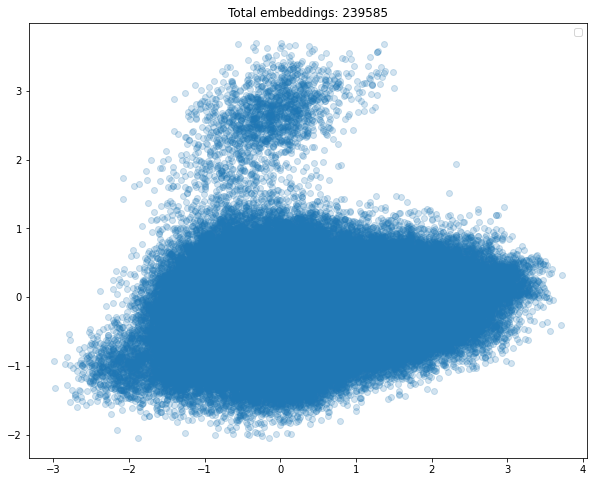

In [21]:
plt.rcParams['figure.figsize'] = [10, 8]

def extractFirstCamel(word, on=False):
    if not on:
        return word
    if len(word) == 0:
        return ''
    if word[0].isupper():
        return word[0]
    else:
        for i in range(1, len(word)):
            if word[i].isupper():
                return word[:i]
        return word

# visualize the top 3 principal components on a 3D plot
fig, ax = plt.subplots()

# He you can set the groups that you are interested in.
# Use relation_groups to select all unified groups.
# selected_relational_groups = relation_groups
# this will only keep the first camel word of the group name
# isUnified = True

# Use to conv to select all groups
# selected_relational_groups = conv[:, 0].astype(int)
# or one of the macros: BROADER, EVALUATES, IMPROVES, INCLUDES, PREDICTS, PROVIDES, REQUIRES, SUPPORTS, USES
selected_relational_groups = [28]
isUnified = False

# frequencies of each group
# group_frequencies = {group: len(np.where(unified_labels == group)[0]) for group in selected_relational_groups}
# print(group_frequencies)

total = 0
for i in selected_relational_groups:
    # use unified_labels or labels here
    selected_labels = np.where(labels == int(i))
    total += len(selected_labels[0])
    ax.scatter(
        transformed[selected_labels, 0],
         transformed[selected_labels, 1],
            alpha=0.2)

    # title the graph
    ax.set_title(f'Total embeddings: {total}')

ax.legend()
plt.show()



In [12]:
# print('Clustering...')
n_relations=len(selected_relational_groups)
n = 50000

# create selected_transformed_indexes which are indexes of the selected relational groups
selected_transformed_indexes = []
for i in selected_relational_groups:
    if isUnified:
        selected_transformed_indexes.append(np.where(unified_labels == int(i)))
    else:
        selected_transformed_indexes.append(np.where(labels == int(i)))

selected_transformed_indexes = np.concatenate(selected_transformed_indexes, axis=1)[0]
selected_transformed = transformed[selected_transformed_indexes]

silhouette_avg = np.zeros(10)
for n_relations in range(2, 10):    
    kmeans = KMeans(n_clusters=n_relations).fit(selected_transformed)
    print(n_relations)
    silhouette_avg[n_relations] = silhouette_score(selected_transformed[:n], kmeans.labels_[:n])
    print(silhouette_avg[n_relations])

2


KeyboardInterrupt: 

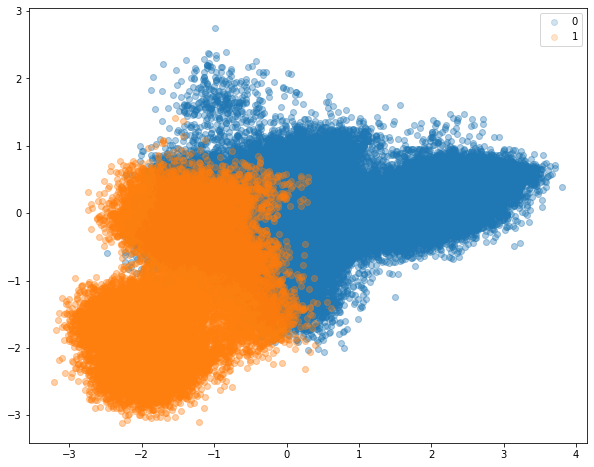

In [23]:
k = 2
kmeans = KMeans(n_clusters=2).fit(selected_transformed)


fig, ax = plt.subplots()
for i in range(k):
    selected_labels = np.where(kmeans.labels_ == i)
    ax.scatter(
        selected_transformed[selected_labels, 0],
         selected_transformed[selected_labels, 1],
           label=i,
            alpha=0.2)
    # ax.set_title(f'Silhouette score: {silhouette_avg}')
ax.legend()
plt.show()

In [55]:
embeddings.shape

(984030, 383)

In [20]:
# cluster_dict = {i: selected_relational_groups[i] for i in range(n_relations)}


coord = kmeans.cluster_centers_[0]
# coord = transformed[119756]

# labelno = 3
# clusterno = np.where(selected_relational_groups == labelno)[0][0]

# Print the closest sentences
# indx = get_closest_n_points(coord, 5)

# Print the closest sentences with the same actual label (notice that the predicted cluster might be different)
# indx = get_closest_n_points(coord, 5, same_label=True, label=labelno)

# Print the closest sentences within the same cluster (notice that the actual label might be different)
indx = get_closest_n_points(coord, 20,same_cluster=True, cluster_id=0)

# Print the closest sentences with the same labels within the the same cluster
# indx = get_closest_n_points(coord, 15, same_label=True, label=labelno,same_cluster=True, cluster_id = 0)

getInfo(indx)

Sentence (id 248515): Large size models are implemented in recently ASR system to deal with complex speech recognition problems. The num- ber of parameters in these models makes them hard to deploy, especially on some resource-short devices such as car tablet.
 
Actual Type: usesOtherEntity 
Word A: parameter
Word B: recognition
Predicted Type: 0
Sentence (id 394505): Scaling parameters for the three properties with halo mass show mild differences among the simulations, in part due to numerical resolution, but there is qualitative agreement on property correlations, with halos having smaller than average central galaxies tending to also have smaller total stellar mass and a larger number of satellite galaxies.
 
Actual Type: narrower 
Word A: parameter
Word B: resolution
Predicted Type: 0
Sentence (id 394504): Scaling parameters for the three properties with halo mass show mild differences among the simulations, in part due to numerical resolution, but there is qualitative agreement on

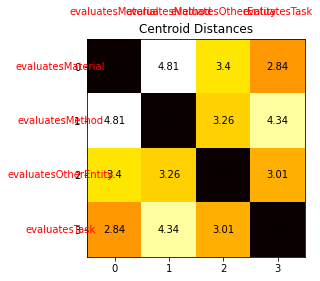

In [13]:
kmeans.cluster_centers_.shape
# plot centroidDistances matrix with labels of the relational groups
fig, ax = plt.subplots()
ax.imshow(centroidDistances(kmeans.cluster_centers_), cmap='hot', interpolation='nearest')

ax.set_xticks(np.arange(n_relations))
ax.set_yticks(np.arange(n_relations))
ax.set_xticklabels(np.arange(n_relations))
ax.set_yticklabels(np.arange(n_relations))

# add labels to the centroidDistances matrix
for i in range(n_relations):
    for j in range(n_relations):
        ax.text(j, i, round(centroidDistances(kmeans.cluster_centers_)[i, j], 2), ha='center', va='center', color='black')
        
# add a string of the relational groups to the centroidDistances matrix on top and on the left side
for i in range(n_relations):
    ax.text(i, -1, extractFirstCamel(conv_dict[selected_relational_groups[i]], on=isUnified), ha='center', va='center', color='red')
    ax.text(-1, i, extractFirstCamel(conv_dict[selected_relational_groups[i]], on=isUnified), ha='center', va='center', color='red')

# Add a title
ax.set_title('Centroid Distances')

plt.show()

In [25]:
kmeans.cluster_centers_.shape

(3, 50)

In [15]:
# Calculate the silhouette score on 10% of the data
print('Calculating silhouette score...')

# 50k takes 30s to run
# 67k takes 50s to run
# 92k takes 100s to run

r = 1
randomized_indexes = np.random.randint(0, len(selected_transformed_indexes), size=int(len(selected_transformed_indexes) * r))
transformed_sample = selected_transformed[randomized_indexes]
labels_sample = kmeans.labels_[randomized_indexes]
print(transformed_sample.shape)
print(labels_sample.shape)

silhouette_score_val = silhouette_score(transformed_sample, labels_sample, metric='euclidean')
print(silhouette_score_val)


Calculating silhouette score...
(30417, 50)
(30417,)
0.119805194


In [16]:
print('Calculating AgglomerativeClustering...')
aglo_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward', compute_distances=True).fit(selected_transformed)
# aglo_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=3, linkage='ward').fit(selected_transformed)


Calculating AgglomerativeClustering...


In [17]:
# print(aglo_clustering.n_clusters_)
print(aglo_clustering.distances_.shape)
print(aglo_clustering.children_.shape)
# print(aglo_clustering.distances_.tolist())

(30416,)
(30416, 2)


In [18]:
# takes 37 min on 26k samples (!!!!!)
# spectral_clustering = SpectralClustering(n_clusters=3, assign_labels='kmeans').fit(selected_transformed)

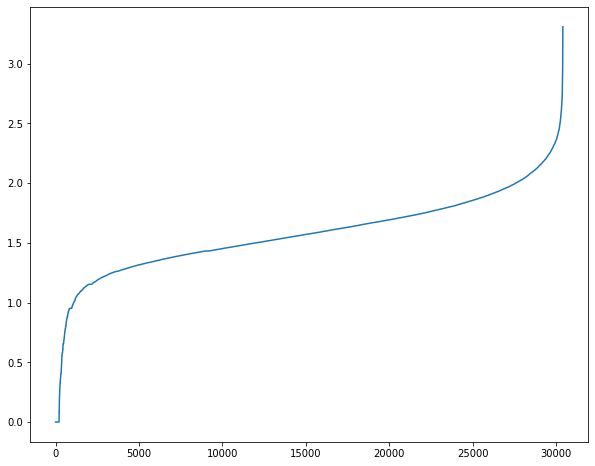

In [ ]:
# run DBSCAN cluster on the selected relational groups
neigh = NearestNeighbors(n_neighbors=2)
# uniformly pick n samples from the 2D np array selected_transformed

# from numpy.random import default_rng
# rng = default_rng()

procentage_of_samples = 0.25
# n = len(selected_transformed)
# tuning_indexes = rng.choice(n, size=int(round(n * procentage_of_samples)), replace=False)
# print(len(tuning_indexes))
# tuning_samples = selected_transformed[tuning_indexes]
# print(selected_transformed.shape)

nbrs = neigh.fit(selected_transformed)
distances, indices = nbrs.kneighbors(selected_transformed)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
print('Calculating the score...')
def purity_score(y_true, y_pred):
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# print(purity_score(unified_labels[selected_transformed_indexes], kmeans.labels_))

print(labels[selected_transformed_indexes].shape)
print(kmeans.labels_.shape)
print('Kmeans score: ', purity_score(labels[selected_transformed_indexes], kmeans.labels_))

Calculating the score...
(30417,)
(30417,)
Kmeans score:  0.7845941414340665


In [ ]:
print('AgglomerativeClustering score: ', purity_score(labels[selected_transformed_indexes], aglo_clustering.labels_))

AgglomerativeClustering score:  0.7444521155932537


In [ ]:
all(aglo_clustering.labels_ == kmeans.labels_)

False

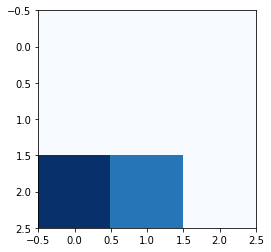

In [16]:
# This I have to fix

matrix = confusion_matrix(unified_labels[selected_transformed_indexes], kmeans.labels_)
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)